# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [37]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
    using Distributions
    using Experiment
    using QuadGK
    using ControlSystemsBase
    using LinearAlgebra
    using ReachabilityAnalysis
end

  Activating project at `~/sc/NoisyReach.jl`


## 2. Validation for Integral function

In [38]:
#const Ts = 0.01
#const Dc = 0.005 # 
#sys = benchmarks[:F1]

In [39]:
#sys_aug_ = let
#    ϕ = ℯ^(Ts * sys.A)
#    Γ₁ = matrix_integral(sys.A, sys.B, Dc, Ts)
#    Γ₀ = matrix_integral(sys.A, sys.B, 0.0, Ts - Dc)
#    ϕ_aug = [ϕ Γ₁; 0 0 0]
#    Γ_aug = [Γ₀; I]
#    C_aug = [sys.C 0]
#    ss(ϕ_aug, Γ_aug, C_aug, sys.D, Ts)
#end

In [40]:
#sys_aug = c2d(sys, Ts) * delay(Dc, Ts)
#sys_aug = c2d(sys, Ts) * thiran(Dc, Ts)

## 3. Physical System and Neural Networks Uncertainty Setup

In [41]:
sys = benchmarks[:F1]
const period = 0.02
const Dc1 = 0.005
const Dc2 = 0.015

0.015

In [42]:
sys_aug = let
    ϕ = ℯ^(period * sys.A)
    Γ2 = matrix_integral(sys.A, sys.B, Dc2, period)
    Γ1 = matrix_integral(sys.A, sys.B, Dc1, Dc2)
    Γ3 = matrix_integral(sys.A, sys.B, 0.0, Dc1)
    ϕ_aug = [ϕ Γ3; 0 0 0]
    Γ_aug = [Γ1 Γ2; 0 I]
    C_aug = [sys.C 0]
    D_aug = [sys.D 0]
    ss(ϕ_aug, Γ_aug, C_aug, D_aug, period)
end
K = lqr(ControlSystemsBase.Discrete, sys_aug.A, sys_aug.B, I, I)

2×3 Matrix{Float64}:
 0.723651  1.09385  0.0995609
 0.307036  0.48328  0.0441294

In [43]:
σ1 = 0.3
σ2 = 0.2
μ = 0.
H = 10
x0 = 1.
u1_0 = 0.
u2_0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u2_0]

3-element Vector{Float64}:
 1.0
 1.0
 0.0

## 4. Calculate and Plot Reachable Trajectories

In [44]:
all_trajectories=[]
number = 2
for i in 1:10000
    z = evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0, σ1, σ2, μ)
    push!(all_trajectories, z)
end
z_ideal = ideal_evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0)

11-element Vector{Vector{Float64}}:
 [1.0, 1.0, 0.0]
 [1.13, 1.0, 0.0]
 [1.2937543264162197, 1.4580106805845718, 0.830229803707528]
 [1.530813474573278, 2.166297491063272, 1.1384929569275255]
 [1.8777435017858917, 3.139442146218545, 1.5671825983478775]
 [2.375916532685912, 4.480781558266105, 2.1629212548102266]
 [3.0828262307835774, 6.333667974674947, 2.9904096880002022]
 [4.078331934607098, 8.896984615623605, 4.139434923155184]
 [5.473323816652889, 12.446675990535715, 5.734595072439676]
 [7.421747587530626, 17.365624594808487, 7.948794160778034]
 [10.137291102745332, 24.185109608311205, 11.021968454955774]

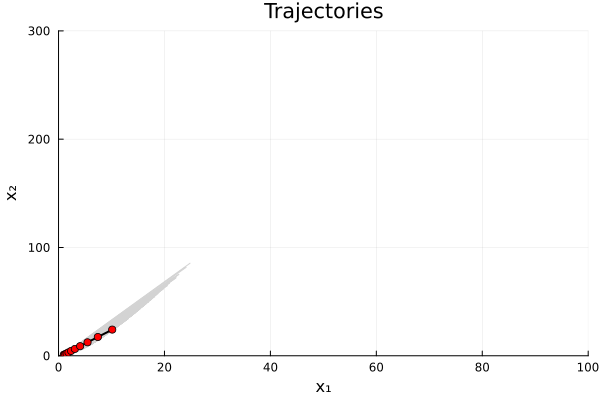

In [45]:
traj_plot = plot(title="Trajectories", xlabel="x₁", ylabel="x₂")
for trajectory in all_trajectories
    x = [point[1] for point in trajectory]
    y = [point[2] for point in trajectory]
    
    plot!(x, y, xlim=(0,100), ylim=(0, 300), label="", linecolor=:lightgray, linewidth=1)#, marker=:circle, markercolor=:yellow, markersize=2)
end
x_z = [point[1] for point in z_ideal]
y_z = [point[2] for point in z_ideal]
plot!(x_z, y_z, xlim=(0,100), ylim=(0, 300), label="", linecolor=:black, linewidth=2, marker=:circle, markercolor=:red, markersize=4)
display(traj_plot)